# Unexpected subgraphs
---

Given an attributed graph $\mathcal{G}=(\mathcal{V, E, A})$, use **unexpectedness** $U=C_w - C$ to filter out attributed subgraphs $G_i=(V_i, E_i, A_i)$.

The unexpectedness of an attributed subgraph $G = (V, E, A)$ is defined as the sum of the unexpectedness of its structure $g$ and the unexpectedness of the set of attributes its nodes are sharing $A$
$$
U(G) = U(g) + U(A)
$$

**Subgraph structure** $g$   
* $U(g)=C_w(g) - C(g)$
* description complexity $C(g)$ is the number of bits to describe vertices and edges in graph  
$C(g) = \log(|V|) + \sum_{v \in V}\log{(b+1)} + \log(\binom{|V|}{k_v})$, with $b=\max_{v \in V}(\text{deg}(v))$ and $k$ is the number of non zero elements in a row  
* generation complexity $C_w(g)$ is the number of bits to describe a random graph sampled in original graph $\mathcal{G}$, with a given number of nodes and density

**Attributes** $A$
* $U(A)=C_w(A)-C(A)$
* description complexity $C(A)$ is the minimum description length for identifying the subgraph sharing characteristics $A \in \mathcal{A}$. It is defined using the number of occurences of each attribute $a \in A$, $\#a$. With this approach, a very common attribute such as '$\texttt{the}$' will yield a large complexity, whereas a non-common attribute will be considered as less complex.  
$C(A)=\sum_{a \in A}\log(\#a)$ 
* generation complexity $C_w(A)$ is the minimum description length to describe a set of $|A|$ elements from a vocabulary of size $\mathcal{A}$  
$C_w(A)=\log(\binom{|\mathcal{A}|}{|A|})$

In [1]:
from collections import defaultdict, Counter
from contextlib import redirect_stdout
from IPython.display import SVG
import matplotlib.pyplot as plt
import numpy as np
import pickle
from random import random
import seaborn as sns
from scipy import sparse, special

from sknetwork.clustering import get_modularity, KMeans, Louvain
from sknetwork.data import load_netset, from_edge_list
from sknetwork.embedding import Spectral, SVD
from sknetwork.gnn import GNNClassifier
from sknetwork.ranking import top_k
from sknetwork.topology import Triangles, Cliques, get_connected_components
from sknetwork.utils import get_degrees, get_membership, get_neighbors
from sknetwork.utils.kmeans import KMeansDense
from sknetwork.utils.check import get_probs
from sknetwork.visualization import svg_graph

from tfidf import TfIdf

In [2]:
wikivitals = load_netset('wikischools')

Parsing files...
Done.


In [3]:
adjacency = wikivitals.adjacency
biadjacency = wikivitals.biadjacency
names = wikivitals.names
words = wikivitals.names_col
labels = wikivitals.labels

In [4]:
print(adjacency.shape, adjacency.nnz)
print(biadjacency.shape, biadjacency.nnz)

(4403, 4403) 112834
(4403, 20527) 474138


In [5]:
def plot_distrib(values, ax, xlabel='degree', log=True, title=None, color='blue', alpha=1, label='Degree distribution'):
    counter = Counter(values)
    x, y = zip(*counter.items())
    ax.scatter(x, y, marker='+', color=color, alpha=alpha, label=label)
    ax.legend()
    ax.set_title(title)
    if log:
        ax.set_xscale('log')
        ax.set_xlabel(xlabel + ' (log)')
    else:
        ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequency' + ' (log)')
    ax.set_yscale('log')
    
def mdl_graph(adjacency):
    n = adjacency.shape[0]

    # density
    #d = np.sum(adjacency) / (n * (n - 1))
    
    # nodes
    nodes_mdl = np.log2(n)
    
    # edges
    degrees = adjacency.dot(np.ones(n))
    max_degree = np.max(degrees)
    edges_mdl = (n + 1) * np.log2(max_degree + 1) + np.sum([np.log2(special.comb(n, deg)) for deg in degrees])

    if n == 1:
        return 1
    else:
        return (nodes_mdl + edges_mdl)

def entropy(prob):
    return prob * -np.log2(prob)

def desc_complexity(attrs):
    if isinstance(attrs, int):
        attrs = [attrs]
    prob = 1
    for attr in attrs:
        prob *= degrees[attr] / np.sum(degrees)
    entr = entropy(prob)
    return generation_complexity(biadjacency.shape[1], len(attrs)) * entr

def expand_list(l, idx, item):
    """If l[idx] does not exists, expand l with item."""
    try:
        l[idx] = item
    except IndexError:
        extents.append(item)    

In [6]:
%%time
complexity_gen_graphs = defaultdict(list)

for num_n in range(adjacency.shape[0] + 1)[1:1000]:
    cpt = 0
    while cpt < 3:
        random_g = sparse.random(num_n, num_n, density=0.5).astype(bool).tocsr()
        if random_g is not None and random_g.shape[0] == num_n:
            mdl = mdl_graph(random_g)
            complexity_gen_graphs[num_n].append(mdl)
            cpt += 1

CPU times: user 1min 48s, sys: 4.38 s, total: 1min 52s
Wall time: 1min 52s


In [7]:
G9 = sparse.csr_matrix(np.array([
    [0, 1, 1, 1, 1, 1, 0, 0],
    [1, 0, 1, 1, 1, 1, 0, 0],
    [1, 1, 0, 1, 1, 1, 0, 0],
    [1, 1, 1, 0, 1, 1, 0, 0],
    [1, 1, 1, 1, 0, 1, 1, 0],
    [1, 1, 1, 1, 1, 0, 1, 0],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 1, 0]
]))
X9 = sparse.csr_matrix(np.array([
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 1, 1, 0, 0, 0],
    [1, 1, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 0, 1],
]))
names9 = np.array(range(G9.shape[0])).astype(str)
names_col9 = np.array(['a', 'b', 'c', 'd', 'e', 'f', 'g'])

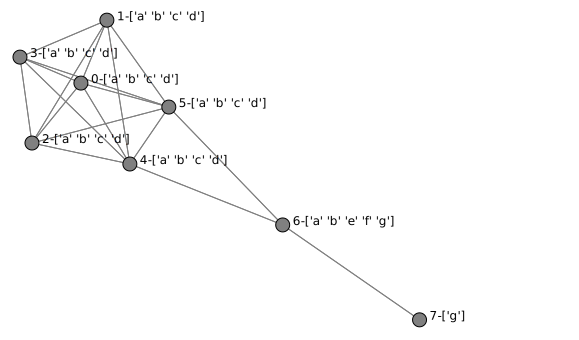

In [8]:
SVG(svg_graph(G9, names=[n + '-' + str(names_col9[x.indices]) for n, x in zip(names9, X9)]))

In [9]:
def is_cannonical(context, extents, intents, r, y):
    global r_new

    for k in range(len(intents[r])-1, -1, -1):
        for j in range(y, intents[r][k], -1):            
            for h in range(len(extents[r_new])):
                if context[extents[r_new][h], j] == 0:
                    h -= 1 # Necessary for next test in case last interaction of h for-loop returns False
                    break
            if h == len(extents[r_new]) - 1:
                return False
        y = intents[r][k] - 1

    for j in reversed(range(y, -1, -1)):
        for h in range(len(extents[r_new])):
            if context[extents[r_new][h], j] == 0:
                h -= 1 # Necessary for next test in case last interaction of h for-loop returns False
                break
        if h == len(extents[r_new]) - 1:
            return False
    
    return True

def extension(attrs, context):
    ext = set()
    if len(attrs) == 0:
        return np.arange(0, context.shape[0])
    for a in attrs:
        nodes = set(get_neighbors(context, node=a, transpose=True))
        if len(ext) == 0:
            ext.update(nodes)
        else:
            ext &= nodes
        if len(ext) == 0:
            break
    return np.asarray(list(ext))

def intention(nodes, context):
    intent = set()
    if len(nodes) == 0:
        return np.arange(0, context.shape[1])
    for n in nodes:
        attrs = set(get_neighbors(context, node=n))
        if len(intent) == 0:
            intent.update(attrs)
        else:
            intent &= attrs
        if len(attrs) == 0:
            break
    return np.asarray(list(intent))

def graph_unexpectedness(adjacency, gen_complexities):
    n = adjacency.shape[0]
    complexity_desc_g = mdl_graph(adjacency)
    complexity_gen_g = np.mean(gen_complexities.get(n))
    return complexity_gen_g - complexity_desc_g

def attr_unexpectedness(biadjacency, attributes, degrees):
    complexity_gen_a = np.log2(special.comb(biadjacency.shape[1], len(attributes)))
    complexity_desc_a = 0
    for a in attributes:
        complexity_desc_a += np.log2(degrees[a])
    return complexity_gen_a - complexity_desc_a

def pattern_unexpectedness(adjacency, biadjacency, gen_complexities, attributes, degrees):
    u_g = graph_unexpectedness(adjacency, gen_complexities)
    u_a = attr_unexpectedness(biadjacency, attributes, degrees)
    return u_g + u_a

In [30]:
def init_inclose(context):
    extents, intents = [], []
    extents_init = np.arange(context.shape[0])
    intents_init = []
    extents.append(extents_init) # Initalize extents with all objects from context
    intents.append(intents_init) # Initialize intents with empty set attributes
    return extents, intents

def in_close_new(adjacency, context, extents, intents, r=0, y=0, min_support=0, max_support=np.inf, degs=[], unexs_g=[], unexs_a=[], unexs=[], names_col=[]):
    global r_new
    r_new = r_new + 1
    
    print(f'NEW ITERATION \n --------')
    print(f'r: {r} - r_new: {r_new}')
    # ------------------------------------------------
    print(f'|extents[r]|: {len(extents[r])} - intents[r]: {names_col[intents[r]]}')
    
    for j in np.arange(context.shape[1])[y:]:
        try:
            extents[r_new] = []
            unexs_g[r_new] = 0
            unexs_a[r_new] = 0
            unexs[r_new] = 0
        except IndexError:
            extents.append([])
            unexs_g.append(0)
            unexs_a.append(0)
            unexs.append(0)
            
        # Form a new extent by adding extension of attribute j to current concept extent
        ext_j = set(extension([j], context))
        extents[r_new] = list(sorted(set(extents[r]).intersection(ext_j)))
        len_new_extent = len(extents[r_new])
        
        print(f'|extents|: {len(extents[r])} - intents: {names_col[intents[r]]}')
        print(f'  Candidate attr: {names_col[j]} - ({j})')
        print(f'  new extent: {extents[r_new]}')
        
        if (len_new_extent > min_support) and (len_new_extent < max_support):
                       
            new_intent = list(sorted(set(intents[r]).union(set([j]))))
            
            # ------------------------------------------------------------------------------------------------------------
            unex_g = graph_unexpectedness(adjacency[extents[r_new], :][:, extents[r_new]], complexity_gen_graphs)
            unexs_g[r_new] = unex_g
            # Attributes unexpectedness
            unex_a = attr_unexpectedness(context, new_intent, degs)
            unexs_a[r_new] = unex_a
            # Total unexpectedness
            unex = unex_g + unex_a
            unexs[r_new] = unex
            print(f'  U(G): {unex_g}')
            print(f'  U(A): {unex_a}')
            print(f'  U: {unex}')
            print(f'unexs: {unexs} r_new: {r_new} - r: {r}')
            # ------------------------------------------------------------------------------------------------------------
            
            if len_new_extent == len(extents[r]):

                if unexs[r_new] - unexs[r_new-1] > 0:
                    print(f'  Extent size did not change -> attribute {names_col[j]} is added to intent.')
                    intents[r] = new_intent
                else:
                    print(f'STOP rec, unexpectedness difference is {unexs[r_new] - unexs[r_new-1]}')
                    break
                
            else:
                print(f'  Extent size DID change. IsCannonical: {is_cannonical(context, extents, intents, r, j - 1)}')
                if is_cannonical(context, extents, intents, r, j - 1):
                    try:
                        intents[r_new] = []
                    except IndexError:
                        intents.append([])

                    intents[r_new] = new_intent 
                    len_new_intent = len(intents[r_new])
                    
                    if unexs[r_new] - unexs[r_new-1] > 0 or r == 0:                    
                        print(f'  --> Enter recursion with Intent: {names_col[intents[r_new]]}...')
                        in_close_new(adjacency, context, extents, intents, r=r_new, y=j+1, min_support=min_support, max_support=max_support, 
                                     degs=degs, unexs_g=unexs_g, unexs_a=unexs_a, unexs=unexs, names_col=names_col)
                    

    print(f'**END FUNCTION')
    print(f'**concept: ({[*zip(extents, intents)]})')
    
    return [*zip(extents, intents)]

In [31]:
# Initialization
extents, intents = init_inclose(biadjacency)
degs = get_degrees(biadjacency, transpose=True)
global r_new
r_new = 0

# Degree of attribute = # articles in which it appears
freq_attribute = get_degrees(biadjacency.astype(bool), transpose=True)
index = np.flatnonzero((freq_attribute <= 1000) & (freq_attribute >= 10))

# Filter data with index
biadjacency = biadjacency[:, index]
words = words[index]
freq_attribute = freq_attribute[index]

# Order attributes according to their ascending degree
# This allows to add first attributes that will generate bigger subgraphs
sort_index = np.argsort(freq_attribute)
sorted_degs = freq_attribute[sort_index]
filt_biadjacency = biadjacency[:, sort_index]
sorted_names_col = words[sort_index]

In [ ]:
# Algorithm
with open('logs/log_wikivitals_inclose_u.txt', 'w') as f:
    with redirect_stdout(f):
        concepts = in_close_new(adjacency, filt_biadjacency, extents, intents, r=0, y=0, 
                                min_support=5, max_support=1000,
                                degs=sorted_degs, unexs_g=[0], unexs_a=[0], unexs=[0], names_col=sorted_names_col)
        print()

print(len(concepts))

In [16]:
# 5564 - speci